In [26]:
import tensorflow as tf
print(tf.version.VERSION)

2.17.0


In [27]:
import matplotlib
import matplotlib.pyplot as plt
import io
import os
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras import layers

In [28]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=45
NUM_CLASSES = 5

In [29]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "processed_images",
    shuffle=True ,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7204 files belonging to 5 classes.


In [30]:
class_names=dataset.class_names
class_names

['1. Eczema',
 '2. Melanoma',
 '4. Basal Cell Carcinoma(BCC)',
 '5. Melanocytic Nevi (NV)',
 '7. Psoriasis pictures Lichen Planus and related diseases']

In [31]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 4 4 1 0 0 3 3 2 2 4 0 0 0 0 4 3 1 1 0 2 2 2 4 3 3 0 4 1 1 2]


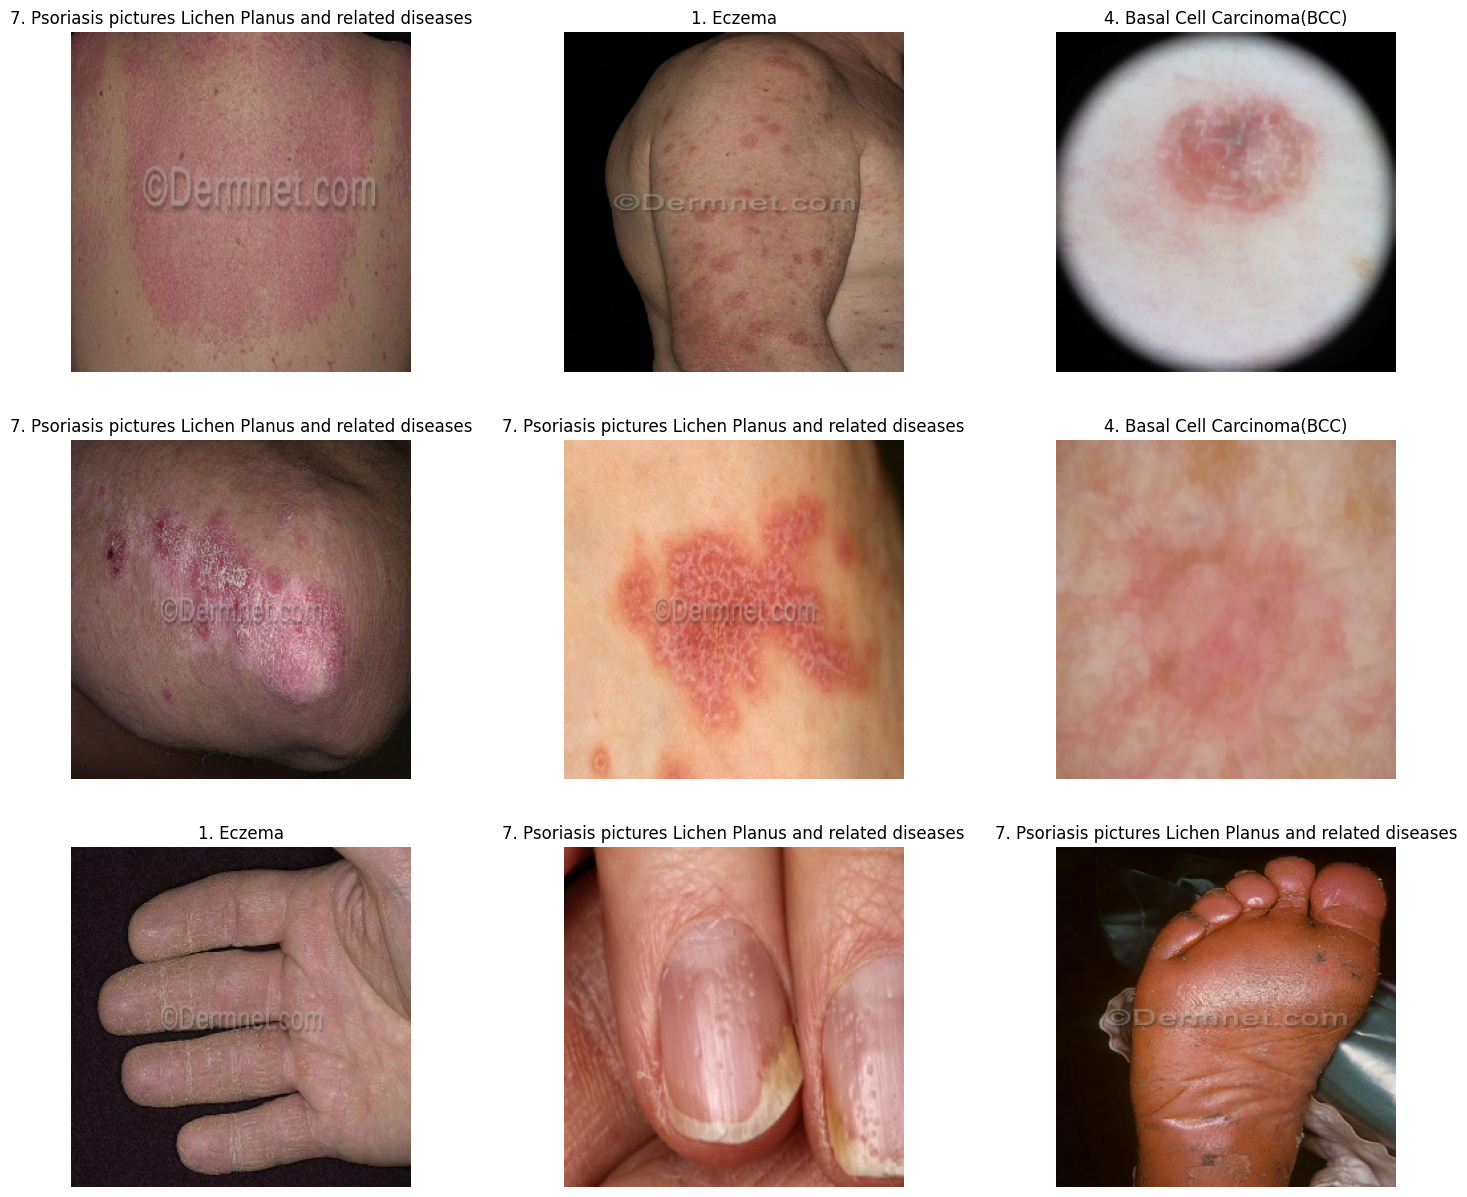

In [32]:
plt.figure(figsize=(18,15))
for i in range(9):
    for image_batch , label_batch in dataset.take(1):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        # print(image_batch[0].shape)
        plt.axis("off")

In [33]:
def get_dataset_partitions_tf(ds,train_split=0.7 , test_split=0.2 , val_split=0.1, shuffle=True , shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size , seed=12)
        train_size=int(train_split*ds_size)
        val_size=int(val_split*ds_size)
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)
    return train_ds ,val_ds ,  test_ds 
    

In [34]:
train_ds , val_ds , test_ds =get_dataset_partitions_tf(dataset)

In [35]:
len(train_ds)

158

In [36]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [38]:
data_augmentation=tf.keras.Sequential([
     tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(0.2),
])

In [39]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

weights_path = 'C:/model_resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

def build_resnet50(input_shape=(256, 256, 3), num_classes=5):
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(weights_path)
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model_resnet = Model(inputs, outputs)

    return model_resnet


model_resnet = build_resnet50(input_shape=(256, 256, 3), num_classes=5)

model_resnet.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

history_resnet = model_resnet.fit(train_ds,
                                  epochs=EPOCHS,
                                  validation_data=val_ds)


Epoch 1/45
158/158 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6677 - loss: 0.9302 - val_accuracy: 0.8338 - val_loss: 0.3695
Epoch 2/45
158/158 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8163 - loss: 0.3993 - val_accuracy: 0.8565 - val_loss: 0.3181
Epoch 3/45
158/158 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8264 - loss: 0.3704 - val_accuracy: 0.8750 - val_loss: 0.2964
Epoch 4/45
158/158 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8526 - loss: 0.3291 - val_accuracy: 0.8707 - val_loss: 0.2834
Epoch 5/45
158/158 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8592 - loss: 0.3112 - val_accuracy: 0.9119 - val_loss: 0.2178
Epoch 6/45
158/158 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8748 - loss: 0.2788 - val_accuracy: 0.9048 - val_loss: 0.2279
Epoch 7/45
158/158 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8650 - loss: 0.2969 - val_accuracy: 0.8707 - val_loss: 0.2637
Epoch 8/45
158/158 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8891 - loss: 0.2495 - val_accu

In [40]:
scores=model_resnet.evaluate(test_ds)

46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9939 - loss: 0.0256


In [41]:
history_resnet.params

{'verbose': 'auto', 'epochs': 45, 'steps': 158}

In [42]:
acc_resnet=history_resnet.history['accuracy']
val_acc_resnet=history_resnet.history['val_accuracy']


loss_resnet=history_resnet.history['loss']
val_loss_resnet=history_resnet.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy for ResNet-50')

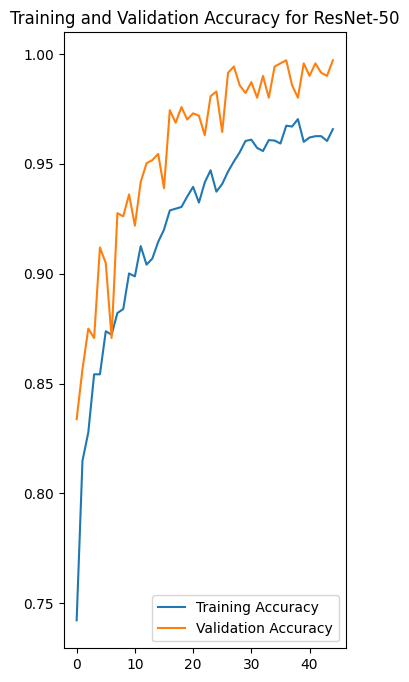

In [43]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc_resnet, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc_resnet,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for ResNet-50')

In [44]:
model_resnet.save("my_model_resNet50_sample3.keras")